In [1]:
!nvidia-smi

Sun May  5 23:30:15 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   30C    P0    50W / 250W |  33225MiB / 40960MiB |     37%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import spaces
import numpy as np
import pickle
from IPython.display import display, clear_output
from matplotlib import animation
from IPython import display as ipythondisplay
import os

is_ipython_env = 'inline' in matplotlib.get_backend()
if is_ipython_env:
    from IPython.display import display, clear_output

plt.ion()


compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Auxilliary Functions

In [3]:


def save_checkpoint(state, filename="DDQNcheckpoint2.pth"):
    torch.save(state, filename)

def load_checkpoint(filename="DDQNcheckpoint2.pth"):
    if os.path.isfile(filename):
        state = torch.load(filename)
        print("Loaded checkpoint '{}'" .format(filename))
        return state
    else:
        print("No checkpoint found at '{}'" .format(filename))
        return None

def display_rewards(show_final=False):
    plt.figure(1)
    plt.clf()
    plt.title('Results' if show_final else 'Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(torch.tensor(total_rewards, dtype=torch.float).numpy())
    if len(total_rewards) >= 50:
        rolling_mean = torch.tensor(total_rewards, dtype=torch.float).unfold(0, 50, 1).mean(1).view(-1)
        rolling_mean = torch.cat((torch.full((49,), -21), rolling_mean))
        plt.plot(rolling_mean.numpy())
    plt.pause(0.001)
    if is_ipython_env and not show_final:
        display(plt.gcf())
        clear_output(wait=True)
    elif show_final:
        display(plt.gcf())

In [4]:

def refine_frame(frame):
    frame = frame[6:189]  
    frame = frame[::2, ::2] 
    frame = frame.astype(np.float32) / 255.0  
    frame = np.transpose(frame, (2, 0, 1))  
    return torch.from_numpy(frame).to(compute_device) 

# Since we are stacking frames hence for four frames 4 frames and 3 RGB channels 12 is used
class ConvDQN(nn.Module):
    def __init__(self, height, width, action_count):
        super(ConvDQN, self).__init__()
        self.conv1 = nn.Conv2d(9, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)


        def compute_conv_output_size(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        conv_width = compute_conv_output_size(compute_conv_output_size(width))
        conv_height = compute_conv_output_size(compute_conv_output_size(height))
        linear_input_size = conv_width * conv_height * 32


        self.fc1 = nn.Linear(linear_input_size, 256)
        self.fc2 = nn.Linear(256, action_count)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


def assemble_state(frames):
    state = torch.cat(tuple(frames), dim=0)
    state = state.unsqueeze(0)
    return state


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def add(self, *args):
        self.memory.append(Transition(*args))

    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


def choose_action(state, eps_threshold):
    global steps_taken
    random_sample = random.random()
    if random_sample > eps_threshold:
        with torch.no_grad():
            return strategy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_space_size)]], device=compute_device, dtype=torch.long)



def refine_model():
    if len(memory_bank) < batch_size:
        return
    sampled_transitions = memory_bank.sample_batch(batch_size)
    batch = Transition(*zip(*sampled_transitions))

    non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=compute_device, dtype=torch.bool)
    non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

   
    current_q_values = strategy_net(state_batch).gather(1, action_batch)


    next_state_actions = strategy_net(non_terminal_next_states).max(1)[1].unsqueeze(1)

 
    next_q_values = torch.zeros(batch_size, device=compute_device)
    next_q_values[non_terminal_mask] = target_net(non_terminal_next_states).gather(1, next_state_actions).squeeze()

   
    expected_q_values = (next_q_values * discount_factor) + reward_batch

  
    loss = nn.SmoothL1Loss()(current_q_values, expected_q_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Initializing Parameters

In [5]:

env = gym.make("Pong-v4")
env.reset()
initial_frame = refine_frame(env.render(mode='rgb_array'))
_, frame_height, frame_width = initial_frame.shape

frame_sequence = deque([initial_frame for _ in range(3)], maxlen=3)
current_state = assemble_state(frame_sequence)
_, _, frame_heaight, frame_width = current_state.shape


batch_size = 64
discount_factor = 0.99
EPSILON_START = 1
EPSILON_END = 0.01
EPSILON_DECAY = 1500
update_target_net_interval = 200
learning_rate = 2e-5
total_episodes = 30000
steps_taken = 0

action_space_size = env.action_space.n
strategy_net = ConvDQN(frame_height, frame_width, action_space_size).to(compute_device)
target_net = ConvDQN(frame_height, frame_width, action_space_size).to(compute_device)
target_net.load_state_dict(strategy_net.state_dict())
target_net.eval() 
optimizer = optim.AdamW(strategy_net.parameters(), lr=learning_rate)
memory_bank = ExperienceReplay(110000)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/user/dsingh27/.local/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/user/dsingh27/.local/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/user/dsingh27/.local/lib/python3.9/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/user/dsingh2

# Training Function

In [6]:

steps_taken = 0
total_rewards = []
epsilon_values = []
episode_counter = 0
steps_done = 0


# Define where to save and set a flag to control whether to continue training
checkpoint_path = "DDQNcheckpoint2.pth"
continue_train = True  # Set this to False if training from scratch

# Load the checkpoint if continue_train is True
if continue_train:
    checkpoint = load_checkpoint(checkpoint_path)
    if checkpoint:
        strategy_net.load_state_dict(checkpoint['strategy_state_dict'])
        target_net.load_state_dict(checkpoint['target_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        total_rewards = checkpoint['total_rewards']
        epsilon_values = checkpoint['epsilon_values']
        episode_counter = checkpoint['episode_counter']
        steps_done = checkpoint['steps_done']
        print('Checkpoint found')
    else:
        total_rewards = []
        epsilon_values = []
        episode_counter = 0
        steps_done = 0
        
else:
    total_rewards = []
    epsilon_values = []
    episode_counter = 0
    steps_done = 0

Loaded checkpoint 'DDQNcheckpoint2.pth'
Checkpoint found


This episode ran for 3885 timesteps


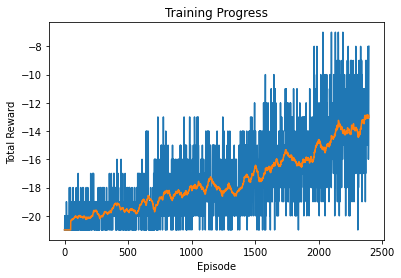

<Figure size 432x288 with 0 Axes>

In [ ]:
i = 0
episodeLength = []
while episode_counter < total_episodes:
    env.reset()
    frame_sequence = deque([refine_frame(env.render(mode='rgb_array')) for _ in range(3)], maxlen=3)
    current_state = assemble_state(frame_sequence)
    episode_reward = 0

    epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1.0 * steps_done / EPSILON_DECAY)
    epsilon_values.append(epsilon)
    steps_done += 1
    episode_counter += 1
    for t in count():
        steps_taken += 1
        if steps_taken % update_target_net_interval == 0:
            target_net.load_state_dict(strategy_net.state_dict())

        action = choose_action(current_state, epsilon)
        _, reward, finished, _ = env.step(action.item())
        episode_reward += reward
        if not finished:
            new_frame = refine_frame(env.render(mode='rgb_array'))
            frame_sequence.append(new_frame)
            next_state = assemble_state(frame_sequence)
        else:
            next_state = None

        reward_tensor = torch.tensor([reward], device=compute_device, dtype=torch.float)
        memory_bank.add(current_state, action, next_state, reward_tensor)
        current_state = next_state if next_state is not None else current_state
        refine_model()
        i+=1
        if finished:
            print(f'This episode ran for {i} timesteps')
            episodeLength.append(i)
            i = 0
            total_rewards.append(episode_reward)
            display_rewards()
            break

    if episode_counter % 50 == 0: 
        save_checkpoint({
            'episode_counter': episode_counter + 1,
            'strategy_state_dict': strategy_net.state_dict(),
            'target_state_dict': target_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'total_rewards': total_rewards,
            'epsilon_values': epsilon_values,
            'steps_done': steps_done
        }, checkpoint_path)



env.close()
display_rewards(show_final=True)
plt.ioff()
plt.show()


# We can see that our Pong agent is winning a few times since rewards are not -21, but less than that in the range of of -8 to -16, so it is winning a few times.

# It is clear that the rewards is increasing continously just that the DDQN agent has to be trained more.
# Also the stability of DDQN looks better than DQN, though the learning rate looks similar.

Loaded checkpoint 'DDQNcheckpoint2.pth'


/user/dsingh27/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Episode 1: Total Reward = -9.0
Episode 2: Total Reward = -7.0
Episode 3: Total Reward = -13.0
Episode 4: Total Reward = -6.0
Episode 5: Total Reward = -7.0
Episode 6: Total Reward = -12.0
Episode 7: Total Reward = -5.0
Episode 8: Total Reward = -4.0
Episode 9: Total Reward = -6.0
Episode 10: Total Reward = -12.0


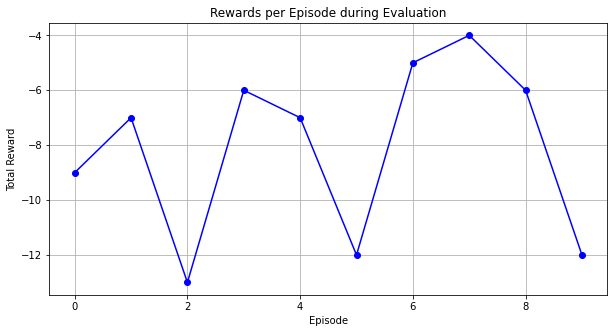

Average reward over 10 episodes: -8.1


In [7]:


def evaluate_model(env, model, num_episodes=10):
    total_eval_rewards = []
    for ep in range(num_episodes):
        state = env.reset()
        frame_sequence = deque([refine_frame(env.render(mode='rgb_array')) for _ in range(3)], maxlen=3)
        state = assemble_state(frame_sequence)
        total_reward = 0
        while True:
            action = model(state).max(1)[1].view(1, 1)  
            _, reward, done, _ = env.step(action.item())
            total_reward += reward
            if not done:
                new_frame = refine_frame(env.render(mode='rgb_array'))
                frame_sequence.append(new_frame)
                state = assemble_state(frame_sequence)
            else:
                break
        total_eval_rewards.append(total_reward)
        print(f'Episode {ep+1}: Total Reward = {total_reward}')
    plot_evaluation_rewards(total_eval_rewards)
    return total_eval_rewards

def plot_evaluation_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, marker='o', linestyle='-', color='b')
    plt.title('Rewards per Episode during Evaluation')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

# Main code
if __name__ == "__main__":
    env = gym.make("Pong-v4")
    checkpoint_path = "DDQNcheckpoint2.pth"
    checkpoint = load_checkpoint(checkpoint_path)
    if checkpoint:
        strategy_net.load_state_dict(checkpoint['strategy_state_dict'])
        strategy_net.eval()  
        total_rewards = evaluate_model(env, strategy_net, num_episodes=10)
        print(f'Average reward over 10 episodes: {sum(total_rewards) / len(total_rewards)}')
    else:
        print("Failed to load a trained model.")
    env.close()


# References:
1. https://karpathy.github.io/2016/05/31/rl/
2. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
3. https://towardsdatascience.com/intro-to-reinforcement-learning-pong-92a94aa0f84d
4. https://huggingface.co/sb3/dqn-PongNoFrameskip-v4
5. https://stable-baselines.readthedocs.io/en/master/guide/examples.html
6. https://github.com/openai/retro/issues/178
7. https://towardsdatascience.com/getting-an-ai-to-play-atari-pong-with-deep-reinforcement-learning-47b0c56e78ae
8. https://wandb.ai/wandb/common-ml-errors/reports/How-to-Save-and-Load-Models-in-PyTorch--VmlldzozMjg0MTE

Checkpoint saving methodology is taken from 8th refernece.
DQN code reference taken from 2nd reference